<a href="https://colab.research.google.com/github/gazalssr/HerdNet/blob/main/dataset_exploration_processing_stratify.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📊 Dataset Exploration and Preprocessing


---


This notebook will help you explore a dataset, from importing the data to visualizing it, including preprocessing and data augmentation steps.

You will also learn how to use the `patcher.py` tool, which allows you to easily split your images into patches using command line interface.

## Installations
First, let's install the dependencies and the source code.

Do not forget to **restart runtime** after executing the cell!


In [1]:
# Check GPU
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [9]:
%%capture --no-stderr
!pip install albumentations==1.0.3
!pip install fiftyone==0.14.3
!pip install hydra-core==1.1.0
!pip install opencv-python==4.5.1.48
!pip install pandas>=1.2.3
!pip install pillow>=8.2.0
!pip install scikit-image>=0.18.1
!pip install scikit-learn>=1.0.2
!pip install scipy>=1.6.2
!pip install wandb==0.10.33

In [10]:
%%capture --no-stderr
import sys

!git clone -b v0.2.0 https://github.com/Alexandre-Delplanque/HerdNet
!pip install -e /content/HerdNet
sys.path.append('/content/HerdNet')

## Download the data

Now we will download a lightweight version of the Delplanque et al. (2022) dataset, which includes nadir drone images of various African mammal species. For more details about the dataset, please refer to the corresponding paper at the following address: https://doi.org/10.1002/rse2.234

In [11]:
#make a zip file from the patch folders
#Zip file path (destination)       source file path

!zip -r '/content/drive/MyDrive/Small_CAH_whole.zip' '/content/drive/MyDrive/Small_CAH_whole'


updating: content/drive/MyDrive/Small_CAH_whole/ (stored 0%)
updating: content/drive/MyDrive/Small_CAH_whole/FCH_7_00_50_MB2.jpg (deflated 0%)
updating: content/drive/MyDrive/Small_CAH_whole/CAH_7_90_2017_BR.jpg (deflated 3%)
updating: content/drive/MyDrive/Small_CAH_whole/CAH_3_50_2017_MB1.jpg (deflated 1%)
updating: content/drive/MyDrive/Small_CAH_whole/CAH_5_50_2017.jpg (deflated 2%)
updating: content/drive/MyDrive/Small_CAH_whole/CAH_1_90_2017.jpg (deflated 2%)
updating: content/drive/MyDrive/Small_CAH_whole/CAH_6SE_50_2017_Q33.jpg (deflated 0%)
updating: content/drive/MyDrive/Small_CAH_whole/CAH_6SE_50_2017_Q23.jpg (deflated 0%)
updating: content/drive/MyDrive/Small_CAH_whole/Small_data_all.csv (deflated 86%)


In [13]:
!pip install --upgrade --no-cache-dir gdown
!gdown https://drive.google.com/uc?id=1pn7My2gjk9BJrsPAlId_HRR2zg0-uYgX -O /content/drive/MyDrive/Small_CAH_whole.zip
# #Zip file location           uzipped file saving location
!unzip -oq /content/drive/MyDrive/Small_CAH_whole.zip -d /content/Small_CAH_whole

Downloading...
From (uriginal): https://drive.google.com/uc?id=1pn7My2gjk9BJrsPAlId_HRR2zg0-uYgX
From (redirected): https://drive.google.com/uc?id=1pn7My2gjk9BJrsPAlId_HRR2zg0-uYgX&confirm=t&uuid=63b491a2-255b-4ba1-a93c-cdb18022f1a4
To: /content/drive/MyDrive/Small_CAH_whole.zip
100% 189M/189M [00:02<00:00, 73.1MB/s]


## First sights
Let's explore the contents of our dataset!

If it doesn't already exist, we will create a new column called 'species' to store the species names. To do this, we first need to create a dictionary that maps label IDs to species names:

In [15]:
 #Set the seed
from animaloc.utils.seed import set_seed

set_seed(9292)

In [16]:
label_to_species = {
    1: 'caribou'
    }

Than, let's plot the distribution of species numbers and display some visual samples:

In [18]:
import pandas
import seaborn
seaborn.set_theme(style="whitegrid")

dataset = pandas.read_csv('/content/drive/MyDrive/Small_CAH_whole/Small_data_all.csv')
dataset['species'] = dataset['labels'].map(label_to_species)

cplot = seaborn.countplot(data=dataset, y='species', palette='viridis', order=label_to_species.values())
counts = cplot.bar_label(cplot.containers[0])

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pdb

The dataset appears to be highly imbalanced, so precautions should be taken during the train-val-test split and model training...

Let's take a look at some samples for each species:

AttributeError: ignored

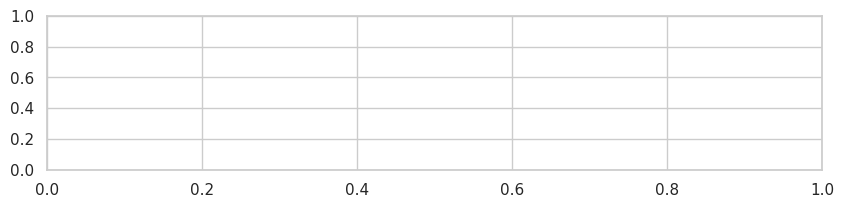

In [21]:
%matplotlib inline
import pdb
import os
from PIL import Image
import matplotlib.pyplot as plt

root = '/content/drive/MyDrive/Small_CAH_whole'
ws = 150 # window size (pixels)
n_species = len(label_to_species)

fig, axes = plt.subplots(nrows=n_species, ncols=1, figsize=(10,2*n_species))
for ax in axes.ravel(): ax.set_axis_off()
for i, sp in enumerate(label_to_species.values()):
    axes[i,0].text(1, 0.5, sp, horizontalalignment='right', verticalalignment='center')
    pdb.set_trace()
for i, (_, sp) in enumerate(label_to_species.items()):
    sp_data = dataset[dataset.species==sp]
    n = 5 if len(sp_data) >= 5 else len(sp_data)

    samples = sp_data.sample(n=n)

    for j, (_, sample) in enumerate(samples.iterrows()):
        img_path = os.path.join(root, sample['images'])
        img = Image.open(img_path)
        bbox = [x + f * ws/2 for f in [-1,1] for x in [sample['x'],sample['y']]]
        crop = img.crop(bbox)
        axes[i,j+1].imshow(crop)

In [ ]:
%pdb off

Automatic pdb calling has been turned OFF



What does a complete image from the dataset look like?

Image size: (8804, 7521)


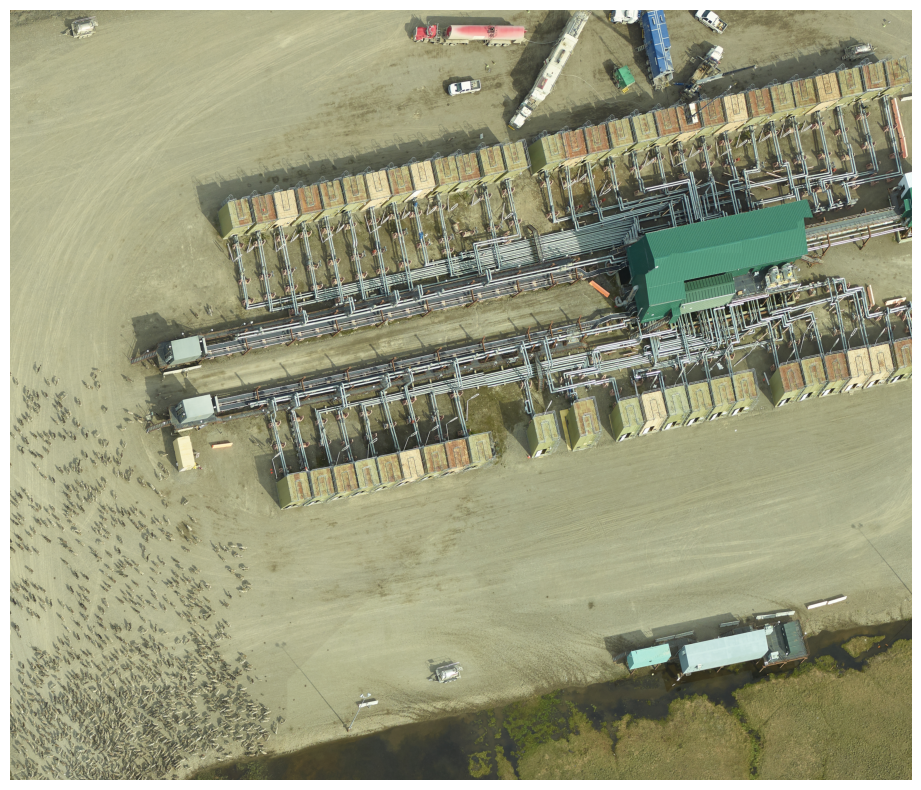

In [22]:
fullimg = Image.open(os.path.join(root, dataset.sample(n=1)['images'].item()))

print(f"Image size: {fullimg.size}")
plt.figure(figsize=(15,10))
_ = plt.imshow(fullimg)
_ = plt.axis('off')

## Dataset split
Let's divide our dataset into 3 subsets: training, validation, and test, according to a common allocation of 70%-10%-20%.

During this process, it is imperative to ensure data independence to avoid bias (i.e. two overlapping images must be in the same subset), and to keep class distribution. Therefore, we'll use scikit-learn's [`StratifiedGroupKFold`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedGroupKFold.html) class in which we can keep both class distribution (stratified) and data independence (group).

For this example, we'll consider the images as independent groups. But if your dataset contains a column defining the group to which each sample belongs (e.g. transect number), specify this column instead.

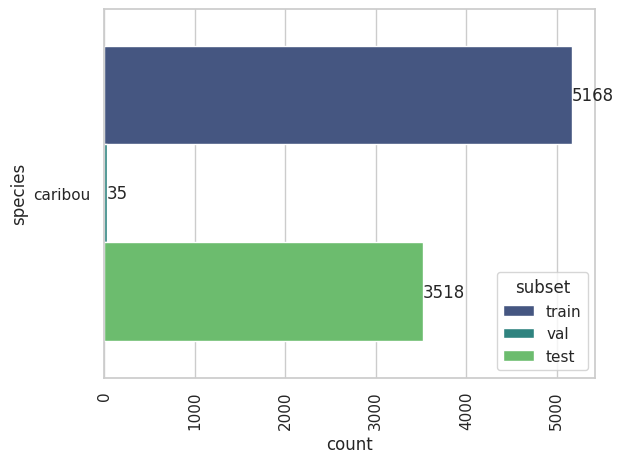

In [23]:
import shutil
from sklearn.model_selection import StratifiedGroupKFold
from animaloc.utils.useful_funcs import mkdir

col_group = 'images'

# 1) Test samples (20%)
sgkf = StratifiedGroupKFold(n_splits=5)
train_val_idx, test_idx = next(iter(sgkf.split(dataset, y=dataset['labels'], groups=dataset[col_group])))

train_val  = dataset.iloc[train_val_idx].reset_index(drop=True)
test = dataset.iloc[test_idx].reset_index(drop=True)
test['subset'] = 'test'

# 2) Train (70%) and val samples (10%)
sgkf = StratifiedGroupKFold(n_splits=8)
train_idx, val_idx = next(iter(sgkf.split(train_val, y=train_val['labels'], groups=train_val[col_group])))

train  = train_val.iloc[train_idx].reset_index(drop=True)
train['subset'] = 'train'
val = train_val.iloc[val_idx].reset_index(drop=True)
val['subset'] = 'val'

dataset = pandas.concat([train, val, test])

# Plot
order = label_to_species.values()

fig, ax = plt.subplots()
ctplot = seaborn.countplot(data=dataset, y='species', hue='subset', palette='viridis', ax=ax, order=order)
for container in ax.containers:
    ax.bar_label(container)

plt.xticks(rotation=90)
plt.tight_layout()

# Move files in dedicated folders and save subsets into .csv files
for subset in ['train','val','test']:
    folder = f'{root}/{subset}'
    files = dataset[dataset['subset']==subset]['images'].unique().tolist()
    mkdir(folder)
    for f in files:
        shutil.move(os.path.join(root, f), os.path.join(folder, f))

train.to_csv(f'{root}/train.csv', index=False)
val.to_csv(f'{root}/val.csv', index=False)
test.to_csv(f'{root}/test.csv', index=False)

## Split entire images into patches
As we have observed, animals occupy only small fractions of the entire images. Moreover, our image size is quite large and may exceed the GPU's memory capacity. Therefore, we need to divide our images into patches to ensure proper training of the model.

Let's start by utilizing the dedicated class called `ImagesToPatches` to observe the results of image splitting. In this case, we will create patches of size 512x512 pixels with a 150-pixel overlap. This is done to ensure that every individual animal appears in its entirety in at least one patch.

Number of patches: 483


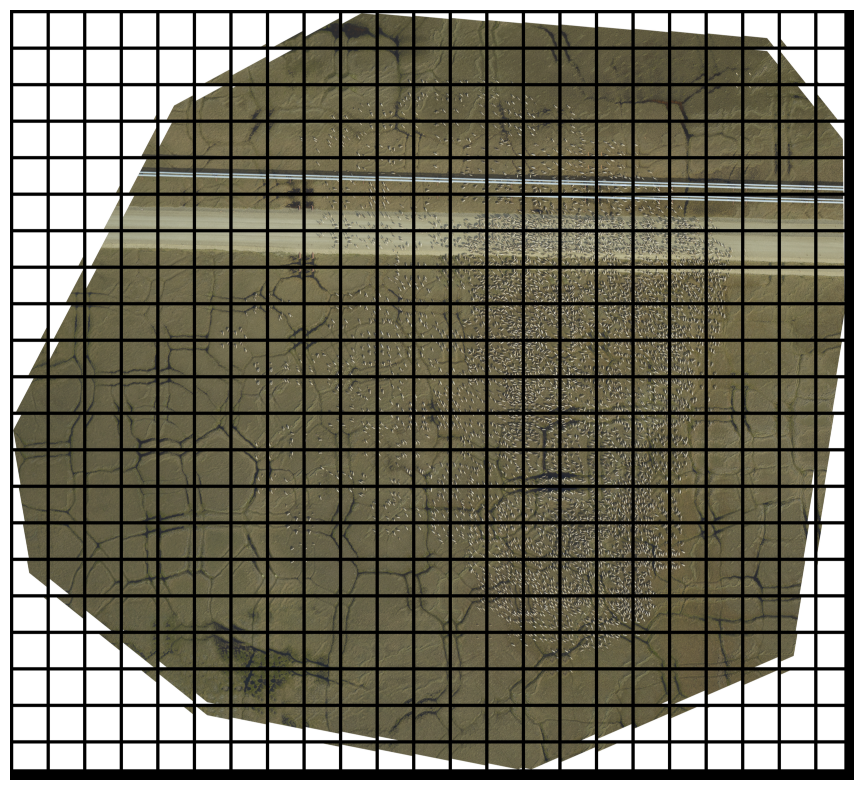

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt
import PIL.Image as Image
root = '/content/drive/MyDrive/Small_CAH_whole/test' or '/content/drive/MyDrive/Small_CAH_whole/train' or '/content/drive/MyDrive/Small_CAH_whole/val'
from animaloc.data.patches import ImageToPatches

sample_img = Image.open(os.path.join(root, dataset.sample(n=1)['images'].item()))

patcher = ImageToPatches(sample_img, (512,512), overlap = 150)
patches = patcher.make_patches()

print(f'Number of patches: {len(patches)}')

plt.figure(figsize=(15,10))
plt.axis('off')
_ = patcher.show()

In [31]:
#make a zip file from the patch folders
#Zip file path (destination)       source file path

!zip -r '/content/drive/MyDrive/Train_stratified.zip' '/content/drive/MyDrive/Small_CAH_whole/train'
!zip -r '/content/drive/MyDrive/val_stratified.zip' '/content/drive/MyDrive/Small_CAH_whole/val'
!zip -r '/content/drive/MyDrive/test_stratified.zip' '/content/drive/MyDrive/Small_CAH_whole/test'

  adding: content/drive/MyDrive/Small_CAH_whole/train/ (stored 0%)
  adding: content/drive/MyDrive/Small_CAH_whole/train/FCH_7_00_50_MB2.jpg (deflated 0%)
  adding: content/drive/MyDrive/Small_CAH_whole/train/CAH_7_90_2017_BR.jpg (deflated 3%)
  adding: content/drive/MyDrive/Small_CAH_whole/train/CAH_5_50_2017.jpg (deflated 2%)
  adding: content/drive/MyDrive/Small_CAH_whole/train/CAH_6SE_50_2017_Q33.jpg (deflated 0%)
  adding: content/drive/MyDrive/Small_CAH_whole/train/CAH_6SE_50_2017_Q23.jpg (deflated 0%)
  adding: content/drive/MyDrive/Small_CAH_whole/train/train.csv (deflated 88%)
  adding: content/drive/MyDrive/Small_CAH_whole/val/ (stored 0%)
  adding: content/drive/MyDrive/Small_CAH_whole/val/CAH_3_50_2017_MB1.jpg (deflated 1%)
  adding: content/drive/MyDrive/Small_CAH_whole/test/ (stored 0%)
  adding: content/drive/MyDrive/Small_CAH_whole/test/CAH_1_90_2017.jpg (deflated 2%)
  adding: content/drive/MyDrive/Small_CAH_whole/test/test.csv (deflated 88%)


## Dont do the rest just save the separated test-train-val patches

In [30]:
ROOT = '/content/drive/MyDrive/Small_CAH_whole' # path to the folder containing entire images
SIZE = 512 # desired patch size
OVERLAP = 150 # desired overlap
DEST = '/content/patches' # destination folder
CSV = '/content/drive/MyDrive/Small_CAH_whole/Small_data_all.csv' # annotation file (.csv)

!mkdir $DEST
!python /content/HerdNet/tools/patcher.py $ROOT $SIZE $SIZE $OVERLAP $DEST -csv $CSV

mkdir: cannot create directory ‘/content/patches’: File exists
Creating the buffer:   0% 0/7 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/content/HerdNet/tools/patcher.py", line 92, in <module>
    main()
  File "/content/HerdNet/tools/patcher.py", line 57, in main
    patches_buffer = PatchesBuffer(args.csv, args.root, (args.height, args.width), overlap=args.overlap, min_visibility=args.min).buffer
  File "/content/HerdNet/animaloc/data/patches.py", line 363, in __init__
    self.buffer = self._create_buffer()
  File "/content/HerdNet/animaloc/data/patches.py", line 384, in _create_buffer
    pil_image = PIL.Image.open(img_path).convert('RGB')
  File "/usr/local/lib/python3.10/dist-packages/PIL/Image.py", line 3227, in open
    fp = builtins.open(filename, "rb")
FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Small_CAH_whole/CAH_1_90_2017.jpg'


Now let's see a batch of patches!

We will begin by creating a dataset using the generated patches. To achieve this, we will utilize the `CSVDataset` class, which is constructed based on a .csv file containing annotations and a root directory that contains the images.

In [ ]:
import os
import torch
import albumentations as A
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

from animaloc.datasets import CSVDataset
from animaloc.data.batch_utils import show_batch, collate_fn
from animaloc.utils.seed import set_seed


set_seed(111) # set the seed to see data augmentation in the next section

csv_file = os.path.join(DEST, 'gt.csv')
root_dir = DEST
csvdataset = CSVDataset(csv_file, root_dir, albu_transforms=[A.Normalize()])
dataloader = DataLoader(csvdataset, batch_size=8, collate_fn=collate_fn, shuffle=True)

sample_batch = next(iter(dataloader))
for i in range(len(sample_batch[1])):
  points = sample_batch[1][i]['points'].numpy()
  minibbox = [[pt[0]-2,pt[1]-2,pt[0]+2,pt[1]+2] for pt in points]
  sample_batch[1][i]['annotations'] = torch.tensor(minibbox)

plt.figure(figsize=(16,2))
show_batch(sample_batch)

AttributeError: ignored

## Data augmentation

Finally, we'll see how to add data augmentation to our dataset and visualize the result on our animal patches.

The `CSVDataset` only supports [Albumentations](https://albumentations.ai/) transformations. To apply transformations, simply add them to the list provided in the `albu_transforms` argument of the dataset:

In [ ]:
set_seed(111)

albu_transforms = [
    A.RandomBrightnessContrast(p=0.5),
    A.Flip(p=0.5),
    A.MotionBlur(blur_limit=15, p=0.5),
    A.RandomRotate90(p=0.5),
    A.Normalize(p=1)
    ]

csvdataset = CSVDataset(csv_file, root_dir, albu_transforms=albu_transforms)
dataloader = DataLoader(csvdataset, batch_size=8, collate_fn=collate_fn, shuffle=True)

sample_batch = next(iter(dataloader))
for i in range(len(sample_batch[1])):
  points = sample_batch[1][i]['points'].numpy()
  minibbox = [[pt[0]-2,pt[1]-2,pt[0]+2,pt[1]+2] for pt in points]
  sample_batch[1][i]['annotations'] = torch.tensor(minibbox)

plt.figure(figsize=(16,2))
show_batch(sample_batch)

NameError: ignored

If you want to test different transformations and their combinations, as well as the impact of changing certain parameter values, feel free to use the Albumentations demo: https://demo.albumentations.ai/